<a href="https://colab.research.google.com/github/deepakk24bcc111-jpg/CICIDS-2017-Dataset-Real-world-network-traffic-with-labeled-attack-data/blob/main/CICIDS_2017_Dataset_%E2%80%93_Real_world_network_traffic_with_labeled_attack_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✔ Dataset Loaded Successfully!

  traffic_type  packet_count  packet_count_per_second  byte_count  \
0       Normal          4122                      112   188875963   
1       Normal          4280                      943   697892057   
2       Normal          6924                      754   534906109   
3       Normal          3695                     1156   598962098   
4       Normal          7147                      373   106331004   

   byte_count_per_second  
0               32613090  
1               13647750  
2               32374543  
3               30985275  
4                9431993  

✔ Model Training Completed!

============= MODEL PERFORMANCE ============
Accuracy  : 1.0
Precision : 1.0
Recall    : 1.0
ROC-AUC   : 1.0



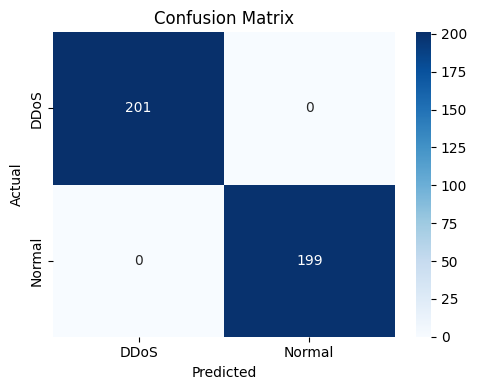

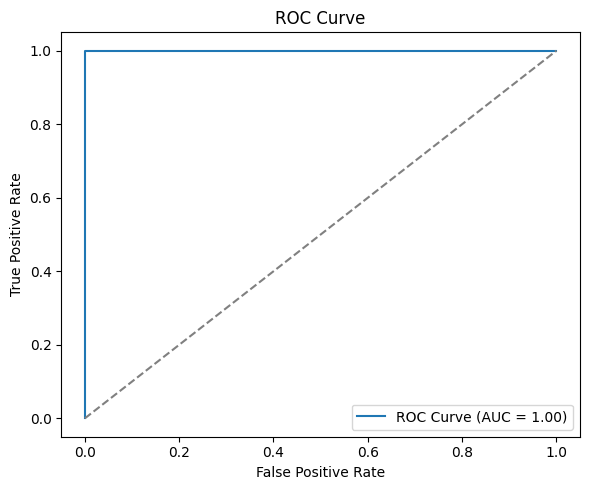

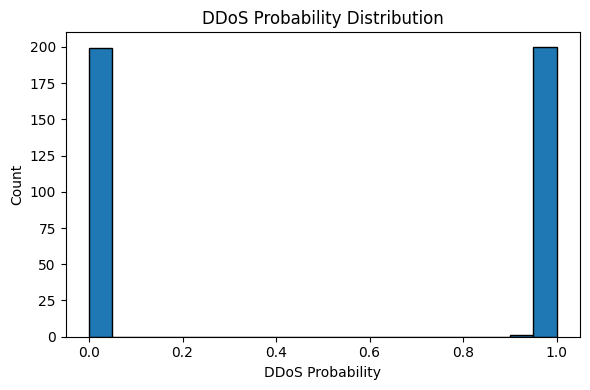


=== TRAFFIC TYPE PREDICTION ===
Predicted Traffic Type : DDoS
DDoS Probability: 0.7250


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, roc_curve, auc
)
df = pd.read_csv("/content/drive/MyDrive/realtime_ddos_traffic_dataset.csv")

print("✔ Dataset Loaded Successfully!\n")
print(df.head())

X = df.drop("traffic_type", axis=1)
y = df["traffic_type"]

numeric_cols = X.select_dtypes(include=['int64','float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))
])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model.fit(X_train, y_train)
print("\n✔ Model Training Completed!")
y_pred = model.predict(X_test)
class_labels = model.named_steps['classifier'].classes_
positive_class_index = list(class_labels).index('DDoS') if 'DDoS' in class_labels else list(class_labels).index('Normal') # Adjust this if positive class is different
y_prob = model.predict_proba(X_test)
y_prob_positive = y_prob[:, positive_class_index]
y_test_binary = y_test.apply(lambda x: 1 if x == class_labels[positive_class_index] else 0)

print("\n============= MODEL PERFORMANCE ============")
print("Accuracy  :", accuracy_score(y_test, y_pred))
print("Precision :", precision_score(y_test, y_pred, average='weighted', zero_division=0))
print("Recall    :", recall_score(y_test, y_pred, average='weighted', zero_division=0))

if len(class_labels) == 2:
    print("ROC-AUC   :", roc_auc_score(y_test_binary, y_prob_positive))
else:
    print("ROC-AUC   : Not directly applicable for multi-class without specific handling.")

print("==============================================\n")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

if len(class_labels) == 2:
    fpr, tpr, thresholds = roc_curve(y_test_binary, y_prob_positive)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0,1], [0,1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("ROC Curve not plotted: Primarily for binary classification.")


plt.figure(figsize=(6,4))
if len(class_labels) == 2:
    plt.hist(y_prob_positive, bins=20, edgecolor="black")
    plt.title(f"{class_labels[positive_class_index]} Probability Distribution")
    plt.xlabel(f"{class_labels[positive_class_index]} Probability")
else:
    plt.hist(y_prob[:, 0], bins=20, edgecolor="black", label=f'Class {class_labels[0]}', alpha=0.6)
    for i in range(1, len(class_labels)):
        plt.hist(y_prob[:, i], bins=20, edgecolor="black", label=f'Class {class_labels[i]}', alpha=0.6)
    plt.title("Class Probability Distribution")
    plt.xlabel("Probability")
    plt.legend()

plt.ylabel("Count")
plt.tight_layout()
plt.show()


sample = pd.DataFrame([
    {
    "packet_count": 50000,
    "packet_count_per_second": 1000,
    "byte_count": 1000000000,
    "byte_count_per_second": 70000000
    }
])
pred = model.predict(sample)[0]
prob = model.predict_proba(sample)[0][positive_class_index]
print("\n=== TRAFFIC TYPE PREDICTION ===")
print("Predicted Traffic Type :", pred)
print(f"{class_labels[positive_class_index]} Probability: {prob:.4f}")